# Access Metrics Made Easy: Nearest Destination and Access Count

### By: Dylan Halpern (2021), M. Kolak (2025+), Adam Cox (2025+), Mallikarjun Bhusnoor (2025+)
#### Last updated: Jan 22, 2025

### Update log
- Updated with Pharmacy 2025 locations (MK)
- Updated on 2025-01-10 with new supportive services data. Removed the deletion of 0's, add added a few sections called 'tips' to provide more information on what's happening. Also commented some sections to be updated, edited, and/or removed. (MK)

---
## Overview
This notebook provides a simple workflow and toolkit to calculate some spatial access metrics. Primarily, this notebook calculates the nearest destination (from the **origin**, or center of a tract or zip code, to the **destination** tract or zip code that contains the resource) and the number of locations within a given threshold (ex. 30-minutes, 60-minutes, 90-minutes).

The basic workflow is as follows:
1. **Import data:** Point data for destinations, origin geographies, and a transit cost matrix of pre-computed travel costs (eg. Minutes, Miles, etc.)
2. **Spatially join destinations to origins:** Based on the geospatial location, this associates each destination with an origin geography. Given that the travel cost between each origin geography is known, we can easily calculate the distance between.
3. **Calculate metrics:** For the nearest location, we'll simply sort the list of origins and destinations by travel time, then take the first entry. For the count within a given threshold, we can filter the list of origins and destinations by the travel time, and count the number of entries under a given threshold.


**Important – make your own copy before editing**

This notebook is shared as **view only**. To save your own work, please:

1. Go to **File → Save a copy in Drive**.
2. Wait for the new tab with your copy to open.
3. Rename it if you like (for example: `opioid_access_notebook_yourname.ipynb`).
4. Do all your edits in **your copy**, not in the shared notebook.

---


## Environment Setup

Install the needed libraries (on the Colab remote machine) and get helper functions set up. Click "go" to run and sit back.

In [ ]:
!pip install pandas==2.2.2 geopandas==1.1.1
!pip install folium matplotlib
import os
import pandas as pd
import geopandas as gpd
import io
import urllib
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

def dfToGdf(df, lon, lat, crs='EPSG:4326'):
  '''
    df: pandas dataframe
    lon: longitude column name
    lat: latitude column name
    crs: EPSG code or similar coordinate reference system
  '''
  return gpd.GeoDataFrame(
    df.drop([lon, lat], axis=1),
    crs=crs,
    geometry=gpd.points_from_xy(df[lon], df[lat])
  ).to_crs("EPSG:4326")


def visualize_geographies_geodataframe(gdf, title="Geography Visualization"):
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    gdf.plot(ax=ax, color="lightblue", edgecolor="black", linewidth=0.2)
    ax.set_xlim(-180, -50)   # zoom horizontally: west to east coast of U.S.
    ax.set_ylim(23, 80)      # zoom vertically: roughly U.S. mainland
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    ax.set_title(title, fontsize=14)
    plt.show()

    return gdf


def visualize_point_geodataframe(gdf, title="Point Data Visualization"):
    """
    Plots all points in the input GeoDataframe.
    """

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    gdf.plot(ax=ax, color="red", markersize=3, alpha=0.7)
    ax.set_title(title, fontsize=14)
    ax.set_xlim(-180, -50)   # zoom horizontally: west to east coast of U.S.
    ax.set_ylim(23, 80)      # zoom vertically: roughly U.S. mainland
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

    return gdf


# This function helps quickly check any point dataset stored online.
# It reads the CSV from the URL, fixes the latitude/longitude column names,
# converts the data into a GeoDataFrame, and plots all points on a simple map.
# Useful for verifying that the coordinates in the dataset are valid and appear
# in the right locations before doing any analysis.
def visualize_point_data_from_url(url, title="Point Data Visualization", lat_field="lat", lon_field="lon"):
    """
    Loads CSV point data from a URL, standardizes latitude/longitude names,
    converts to a GeoDataFrame, and plots all locations.
    Useful for visually verifying S3-hosted point datasets.
    """

    print(f"Loading point data from:\n{url}\n")

    df = pd.read_csv(url, encoding="latin1")

    # Check required columns
    if lat_field not in df.columns or lon_field not in df.columns:
        print(f"ERROR: {lat_field} or {lon_field} column not found in the dataset.")
        print("Available columns:", df.columns.tolist())
        print("You may need to define different columns in this function's args.")
        return None

    gdf = dfToGdf(df, lon_field, lat_field)

    visualize_point_geodataframe(gdf, title)

    return gdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.4/338.4 kB 6.4 MB/s eta 0:00:00
  Attempting uninstall: geopandas
    Found existing installation: geopandas 1.1.2
    Uninstalling geopandas-1.1.2:
      Successfully uninstalled geopandas-1.1.2


### Public data
We've provided a set of public datasets to help get you started. Specifically, we have travel cost matrices for U.S. zip code tabulation areas and census tracts using a 2010 base vintage (with a few updates included in 2018), with the *travel cost* measured as a value in minutes.

The data here is in the *Apache Parquet* format, an efficient format for storing tabular data.

We've also included some base geographies and population data (should you need it) and some sample destination data of Federally Qualified Health Clinics (FQHC's).

In [ ]:
## lookup for all access matrices
matrices = {
  # 2010 base vintage, 2018 edition
  2010: {
    'tract': {
      'car':'https://matrices-collab-notebook.s3.us-east-2.amazonaws.com/US-matrix-TRACT-DRIVING.parquet',
      'bike':'https://matrices-collab-notebook.s3.us-east-2.amazonaws.com/US-matrix-TRACT-BICYCLE.parquet',
      'walk':'https://matrices-collab-notebook.s3.us-east-2.amazonaws.com/US-matrix-TRACT-WALKING.parquet'
    }
  },
  2020: {
    'tract': {
      'car': 'https://matrices-collab-notebook.s3.us-east-2.amazonaws.com/TCM-SVI2022-Drive-192km-90min-round.parquet',
      'bike':'https://matrices-collab-notebook.s3.us-east-2.amazonaws.com/TCM-SVI2022-Bike-24km-90min-round.parquet',
      'walk':'https://matrices-collab-notebook.s3.us-east-2.amazonaws.com/TCM-SVI2022-Walk-6km-90min-round.parquet'
    }
  }
}

## lookup for all geography file options
geographies = {
  2010: {
    'tract': 'https://herop-geodata.s3.us-east-2.amazonaws.com/census/tract-2010-500k-shp.zip',

  },
  2020: {
    'tract': 'https://herop-geodata.s3.us-east-2.amazonaws.com/census/tract-2020-500k-shp.zip',
  }
}


sample_point_data19 = {
    'FQHC': 'https://matrices-collab-notebook.s3.us-east-2.amazonaws.com/context_fqhc_clinics_hrsa.csv',
    'opioid_treatment_facilities': 'https://matrices-collab-notebook.s3.us-east-2.amazonaws.com/Opioid_Treatment_Directory_Geocoded.csv',
    'moud_full': 'https://matrices-collab-notebook.s3.us-east-2.amazonaws.com/us-wide-moudsCleaned_geocoded.csv',
    'moud1': 'https://matrices-collab-notebook.s3.us-east-2.amazonaws.com/us-wide-moudsCleaned_geocoded1.csv',
    'moud2': 'https://matrices-collab-notebook.s3.us-east-2.amazonaws.com/us-wide-moudsCleaned_geocoded2.csv',
    'moud3': 'https://matrices-collab-notebook.s3.us-east-2.amazonaws.com/us-wide-moudsCleaned_geocoded3.csv'
}

sample_point_data25 = {
    'FQHC': 'https://matrices-collab-notebook.s3.us-east-2.amazonaws.com/context_fqhc_clinics_hrsa.csv',
    'MET' : 'https://matrices-collab-notebook.s3.us-east-2.amazonaws.com/MET_2025.csv',
    'OTPR' : 'https://matrices-collab-notebook.s3.us-east-2.amazonaws.com/Opioid_Treatemnt_Programs_2025.csv',
    'OTPR_N' : 'https://matrices-collab-notebook.s3.us-east-2.amazonaws.com/Opioid_Treatemnt_Programs_2025_G.csv', # Mallikarjun - Same as the above OTP csv, just updated the filed names with as per the function
    'BUP' : 'https://matrices-collab-notebook.s3.us-east-2.amazonaws.com/BUP_2025.csv',
    'NAL_TELE' : 'https://matrices-collab-notebook.s3.us-east-2.amazonaws.com/Naltrexone_Telehealth_2025.csv',
    'NAL' : 'https://matrices-collab-notebook.s3.us-east-2.amazonaws.com/NAL_2025.csv',
    'SUPPORTIVE' : 'https://raw.githubusercontent.com/healthyregions/loud-study/refs/heads/main/indicators_raw/us-supportive-services.csv',
    'ABSTINENCE' : 'https://raw.githubusercontent.com/healthyregions/loud-study/refs/heads/main/indicators_raw/us-abstinence-services2.csv',
    'PHARM' : 'https://raw.githubusercontent.com/healthyregions/loud-study/refs/heads/main/indicators_raw/Pharmacy.csv'
}

geoid_cols = {
    "tract":"GEO_ID",
    "zip": "GEOID10"
}

## Define parameters

Here you will set some high-level parameters that determine the nature of our analysis.

- **GEOGRAPHIC_UNIT**
    - This should be "tract"
- **ANALYSIS_YEAR**
    - This year will determine which vintage of geography boundaries to use.
    - This year is also used to lookup the corresponding transit matrix
    

In [ ]:
GEOGRAPHIC_UNIT = "tract"
ANALYSIS_YEAR = 2020


Now we can load this geography data into our session.

In [ ]:
GEOGRAPHIES = gpd.read_file(geographies[ANALYSIS_YEAR][GEOGRAPHIC_UNIT]).to_crs('EPSG:4326')
print(GEOGRAPHIES.shape, GEOGRAPHIES.crs)
print(GEOGRAPHIES.columns)
print(GEOGRAPHIES.head())

(85187, 21) EPSG:4326
Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'AFFGEOID', 'GEOID', 'NAME',
       'NAMELSAD', 'STUSPS', 'NAMELSADCO', 'STATE_NAME', 'LSAD', 'ALAND',
       'AWATER', 'HEROP_ID', 'minx', 'miny', 'maxx', 'maxy', 'BBOX', 'LABEL',
       'geometry'],
      dtype='object')
  STATEFP COUNTYFP TRACTCE              AFFGEOID        GEOID    NAME  \
0      01      089  011021  1400000US01089011021  01089011021  110.21   
1      01      095  031200  1400000US01095031200  01095031200     312   
2      01      073  012401  1400000US01073012401  01073012401  124.01   
3      01      073  003400  1400000US01073003400  01073003400      34   
4      01      073  010402  1400000US01073010402  01073010402  104.02   

              NAMELSAD STUSPS        NAMELSADCO STATE_NAME  ...     ALAND  \
0  Census Tract 110.21     AL    Madison County    Alabama  ...  11286806   
1     Census Tract 312     AL   Marshall County    Alabama  ...  28927220   
2  Census Tract 124.01     AL  Jefferson Cou

Now that the geographies are loaded, we will split the HEROP_ID field into its two different parts, one of which becomes a FIPS field that we will use later.

In [ ]:
GEOGRAPHIES[['summary_level', 'FIPS']] = GEOGRAPHIES["HEROP_ID"].str.split("US", expand=True)
GEOGRAPHIES['FIPS'] = GEOGRAPHIES['FIPS'].astype('int64')

## Define input dataset

Next we will set the CSV input data that will be used for the analysis. You can use the file explorer in the left-hand panel (folder icon) to upload your own CSV file. Then set the path to that file below.

Alternatively, you can use one of the lookups for our sample data.

In [ ]:

## here is a reference to one of our sample datasets
INPUT_CSV = sample_point_data25['PHARM']

## You can also uncomment this line and set the path to a file that you have
## uploaded to this notebook's storage
#INPUT_CSV = 'geocoded_nasen1.csv'


Now we can load this input CSV to a dataframe so we can begin working with it.

***Tip:*** Be sure to change the "longitude" and "latitude" terms with the equivalent coordinate column names in your CSV. This could be 'longitude', 'latitude' OR 'lon', 'lat' for example.


In [ ]:
DESTINATIONS = dfToGdf(pd.read_csv(INPUT_CSV), 'lon','lat')

## Visual inspection of inputs

The following blocks allow you to create some visual checks to make sure your select data has loaded properly. In the last one, you will confirm that you have loaded the correct input CSV and geography data.

#### MK Notes
- Let's move the copy/paste to the last graphic, where the choropleth map of final data product is shown. This step is for a quick inspection only, to confirm that things are plotting correctly.
- Check that lat/long were input correctly
- Check the right projection is being used. If a transformation is needed, it should be updated.


### Show input data

Let's see what the destinations dataset you have provided looks like.

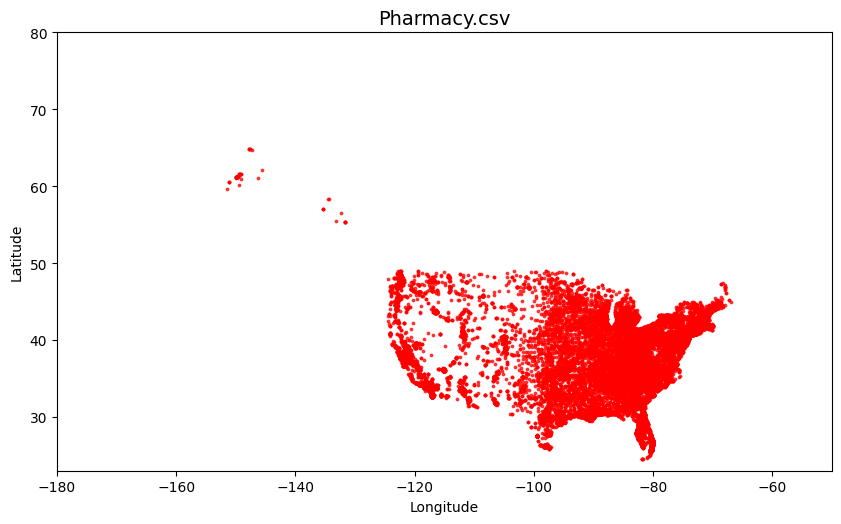

,name,address,city,state,zip,confidence,geometry
0,Raincity Drugstore,305 Dock St,Ketchikan,AK,99901,0.96,POINT (-131.64731 55.34203)
1,Safeway,2417 Tongass Ave,Ketchikan,AK,99901,0.97,POINT (-131.674 55.34832)
2,Carrs Pharmacy,2417 Tongass Ave,Ketchikan,AK,99901,0.96,POINT (-131.67374 55.3484)
3,Island Pharmacy,3526 Tongass Ave,Ketchikan,AK,99901,0.99,POINT (-131.69265 55.35586)
4,Walmart,4230 Don King Rd,Ketchikan,AK,99901,0.95,POINT (-131.72057 55.37547)
...,...,...,...,...,...,...,...
40130,Farmacia San Antonio,98 PR-110,Aguadilla,NaN,00690,0.96,POINT (-67.10009 18.4971)
40131,Farmacia Carimar,7032 Avenida Agustin Ramos Calero,Isabela,NaN,00662,0.96,POINT (-67.02553 18.49931)
40132,Super Pharmacy Rebeca,80 Avenida Noel Estrada,Isabela,NaN,00662,0.96,POINT (-67.02015 18.49963)
40133,Farmacia Chaves,34 Calle Barbosa,Isabela,NaN,00662,0.96,POINT (-67.02347 18.50051)


In [ ]:
title = Path(INPUT_CSV).name
visualize_point_geodataframe(DESTINATIONS, title)

### Show geographies

Let's see what the geographic boundaries you have selected look like.

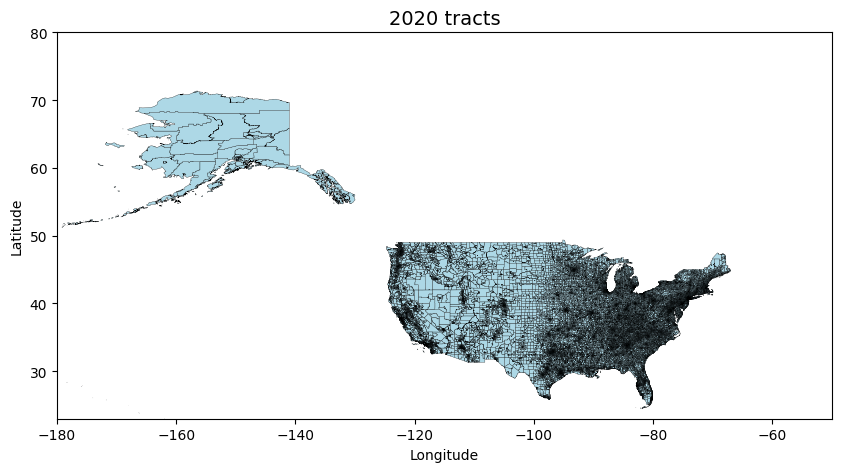

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,NAMELSADCO,STATE_NAME,...,HEROP_ID,minx,miny,maxx,maxy,BBOX,LABEL,geometry,summary_level,FIPS
0,01,089,011021,1400000US01089011021,01089011021,110.21,Census Tract 110.21,AL,Madison County,Alabama,...,140US01089011021,-86.786928,34.662612,-86.738957,34.701062,"-86.787,34.663,-86.739,34.701",Census Tract 110.21,"POLYGON ((-86.78688 34.66425, -86.78686 34.665...",140,1089011021
1,01,095,031200,1400000US01095031200,01095031200,312,Census Tract 312,AL,Marshall County,Alabama,...,140US01095031200,-86.174017,34.186232,-86.105611,34.242675,"-86.174,34.186,-86.106,34.243",Census Tract 312,"POLYGON ((-86.17402 34.23036, -86.17375 34.230...",140,1095031200
2,01,073,012401,1400000US01073012401,01073012401,124.01,Census Tract 124.01,AL,Jefferson County,Alabama,...,140US01073012401,-86.907392,33.551775,-86.870453,33.579818,"-86.907,33.552,-86.87,33.58",Census Tract 124.01,"POLYGON ((-86.90739 33.57448, -86.90562 33.575...",140,1073012401
3,01,073,003400,1400000US01073003400,01073003400,34,Census Tract 34,AL,Jefferson County,Alabama,...,140US01073003400,-86.911810,33.497386,-86.892087,33.515227,"-86.912,33.497,-86.892,33.515",Census Tract 34,"POLYGON ((-86.91149 33.50122, -86.91043 33.502...",140,1073003400
4,01,073,010402,1400000US01073010402,01073010402,104.02,Census Tract 104.02,AL,Jefferson County,Alabama,...,140US01073010402,-86.990940,33.370563,-86.968909,33.393076,"-86.991,33.371,-86.969,33.393",Census Tract 104.02,"POLYGON ((-86.99094 33.37425, -86.98051 33.386...",140,1073010402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85182,78,030,960800,1400000US78030960800,78030960800,9608,Census Tract 9608,VI,St. Thomas Island,United States Virgin Islands,...,140US78030960800,-64.984135,18.306344,-64.940263,18.356987,"-64.984,18.306,-64.94,18.357",Census Tract 9608,"MULTIPOLYGON (((-64.96089 18.31373, -64.96012 ...",140,78030960800
85183,78,030,961200,1400000US78030961200,78030961200,9612,Census Tract 9612,VI,St. Thomas Island,United States Virgin Islands,...,140US78030961200,-64.931285,18.337467,-64.921285,18.351489,"-64.931,18.337,-64.921,18.351",Census Tract 9612,"POLYGON ((-64.93128 18.34585, -64.93069 18.345...",140,78030961200
85184,78,010,970300,1400000US78010970300,78010970300,9703,Census Tract 9703,VI,St. Croix Island,United States Virgin Islands,...,140US78010970300,-64.745176,17.739356,-64.711537,17.767484,"-64.745,17.739,-64.712,17.767",Census Tract 9703,"POLYGON ((-64.74518 17.75544, -64.73957 17.757...",140,78010970300
85185,78,030,960200,1400000US78030960200,78030960200,9602,Census Tract 9602,VI,St. Thomas Island,United States Virgin Islands,...,140US78030960200,-64.906363,18.322708,-64.866780,18.344790,"-64.906,18.323,-64.867,18.345",Census Tract 9602,"POLYGON ((-64.90636 18.3311, -64.90538 18.3356...",140,78030960200


In [ ]:
title = f"{ANALYSIS_YEAR} {GEOGRAPHIC_UNIT}s"
visualize_geographies_geodataframe(GEOGRAPHIES, title=title)

## Load the transit matrix

Here we will load the transit matrix for our analysis into the session, and then print some stats about the table, like number of rows and columns (`df.shape`), the first five rows (`df.head`), and the datatypes of the columns (`df.dtypes`).

TRANSIT_MODE: sets the mode of transportation for travel time
  'car', 'bike', or 'walk'

Each row in the transit matrix tells us:

- `origin` → where the trip starts
- `destination` → where the trip ends (like a facility ZIP)
- `minutes` → travel time between them

In [ ]:
TRANSIT_MODE = "car"    # 'car' | 'bike' | 'walk'
url = matrices[ANALYSIS_YEAR][GEOGRAPHIC_UNIT][TRANSIT_MODE]
print("loading:", url)
TRANSIT_MATRIX = pd.read_parquet(url)
print(TRANSIT_MATRIX.shape)
print(TRANSIT_MATRIX.head())
print(TRANSIT_MATRIX.dtypes)

loading: https://matrices-collab-notebook.s3.us-east-2.amazonaws.com/TCM-SVI2022-Drive-192km-90min-round.parquet
(119043765, 3)
        origin  destination  minutes
0  28047003506   1097000200    86.49
1  28047003506   1097000401    87.96
2  28047003506   1097000402    88.44
3  28047003506   1097000500    88.36
4  28047003506   1097000600    89.54
origin           int64
destination      int64
minutes        float64
dtype: object


In [ ]:
# drop any values with negative minutes (-1000 show up in the 2010 access matrices)
if TRANSIT_MATRIX['minutes'].min() < 0:
  print("dropping rows with minute values under 0")
  TRANSIT_MATRIX = TRANSIT_MATRIX[TRANSIT_MATRIX['minutes'] > 0]

print(TRANSIT_MATRIX['minutes'].describe())
print(TRANSIT_MATRIX.shape)

count    1.190438e+08
mean     4.731688e+01
std      2.414374e+01
min      0.000000e+00
25%      2.668000e+01
50%      4.594000e+01
75%      6.835000e+01
max      9.000000e+01
Name: minutes, dtype: float64
(119043765, 3)



Find the nearest destination for each origin

This step identifies the closest destination for every origin (ZIP or tract) based on travel time.

groupby('origin') organizes the data so we look at each origin separately.

['minutes'].idxmin() finds the row with the smallest travel time for that origin, meaning the nearest destination.

.loc[...] then retrieves those specific rows from the full dataset.

The resulting table shows:
1. origin       → the starting area
2. destination  → the closest facility
3. minutes      → travel time to reach it

Each origin appears only once, paired with its single nearest destination.

---

***Tip:*** If a resource exists within a censust tract, the travel time will have a value of zero, meaning excellent potential spatial accessibility. Obviously, this is an approximation or estimate of access. Calculating travel from geographic unit centroids allow for scalability in measuring potential access across the entire country. The tradeoff is that potential access within a census tract is an approximation.

In [ ]:
nearest = TRANSIT_MATRIX.loc[TRANSIT_MATRIX.groupby('origin')['minutes'].idxmin()]
nearest.head()


,origin,destination,minutes
534656,1001020100,1001020100,0.0
600781,1001020200,1001020200,0.0
488948,1001020300,1001020300,0.0
638580,1001020400,1001020400,0.0
592891,1001020501,1001020501,0.0


### Spatial Join
Spatially joining points and polygons is easy. We're using the `intersects` geometric predicate here, simply meaning that if a point intersects a polygon, those two become joined or associated.

This means that we are able to see which polygon from our geographies each destination is in, and from the travel matrix, we'll know how far it is (roughly) from the other geographies.


#### MK notes
- Will need to better integrate comments within the code, into the markdown document. Code and commentary should be separated, etc.


#### This step connects each destination point to the geographic area (tract or ZIP) it falls within.

#### The function gpd.sjoin() checks where each point lies relative to the polygons in the GEOGRAPHIES layer.

#### We use the “intersects” option, which means that if a point touches or lies inside a polygon, it gets matched to that polygon.

#### The result is a new dataset (merged_destinations) that contains information from both layers:
#####       • Facility details such as name, address, and phone number
#####      • The corresponding geographic identifier (FIPS) for where that facility is located

####This helps us know exactly which geographic unit each facility belongs to,so we can later link it with the travel-time matrix and calculate accessibility measures.

In [ ]:
merged_destinations = gpd.sjoin(DESTINATIONS, GEOGRAPHIES[['FIPS', 'geometry']], how='inner', predicate='intersects')
merged_destinations.head()

,name,address,city,state,zip,confidence,geometry,index_right,FIPS
0,Raincity Drugstore,305 Dock St,Ketchikan,AK,99901,0.96,POINT (-131.64731 55.34203),1544,2130000300
1,Safeway,2417 Tongass Ave,Ketchikan,AK,99901,0.97,POINT (-131.674 55.34832),1592,2130000200
2,Carrs Pharmacy,2417 Tongass Ave,Ketchikan,AK,99901,0.96,POINT (-131.67374 55.3484),1592,2130000200
3,Island Pharmacy,3526 Tongass Ave,Ketchikan,AK,99901,0.99,POINT (-131.69265 55.35586),1592,2130000200
4,Walmart,4230 Don King Rd,Ketchikan,AK,99901,0.95,POINT (-131.72057 55.37547),1592,2130000200


### Moins Est Plus
Less is more, let's just snag the columns we need. We'll need to join this data again to the travel matrix, so the second line gets everyone speaking the same language.

The goal here is to keep the data clean and light by only selecting the columns that we actually need for the next steps.

From the merged dataset, we extract:
1. “index_right” – identifies which record in the geographic layer the facility belongs to.
2. “FIPS” – the geographic code (tract or ZIP) that uniquely identifies that area.

We then make sure the FIPS column is in the correct numeric format (int64),so that it can be easily merged with other datasets like the travel-time matrix later on.

The warning message that may appear during conversion can be ignored, since it’s just reminding us that we’re changing the column type intentionally.

The final result is a smaller and cleaner table, ready for joining with other data sources in the next steps.

In [ ]:


## Pull out the simplified columns we need for the analysis
destinations_simplified = merged_destinations[['index_right','FIPS']]

## Type correctly to merge
## Ignore that warning this is fine
destinations_simplified.loc[:,'FIPS'] = destinations_simplified['FIPS'].astype('int64')
destinations_simplified.head()

,index_right,FIPS
0,1544,2130000300
1,1592,2130000200
2,1592,2130000200
3,1592,2130000200
4,1592,2130000200


### The Big Join
Currently, we have destinations associated with our origin geographies (if you're using the default data, census tracts and health clinics), but we need to bring it all together by joining the origins and destinations to the travel matrix. Below, we'll join the travel matrix to the destinations:

In [ ]:

merge_transit_matrix = TRANSIT_MATRIX.merge(destinations_simplified, left_on="destination", right_on="FIPS")
merge_transit_matrix.count()
merge_transit_matrix.head()
merge_transit_matrix['minutes'].describe()

,minutes
count,5.950536e+07
mean,4.674205e+01
std,2.410170e+01
min,0.000000e+00
25%,2.618000e+01
50%,4.488000e+01
75%,6.766000e+01
max,9.000000e+01


### Analysis Time
Let's get down to business. To begin, let's declare some variables that will help us a bit later. To start, we can define what our origin column (by default, creatively, `origin`), the destination ID column that came from the destinations data, the travel cost column, and the treshold for travel time.

In [ ]:
origin_col = 'origin'
destination_id_col = 'index_right'
travel_cost_col = 'minutes'
travel_threshold = 30

#### Data Cleanup
Lets check if we have some outliers or weird values in the matrix... We have some weird -1000 values.

In [ ]:
pd.options.display.float_format = '{:.2f}'.format
merge_transit_matrix['minutes'].describe()

,minutes
count,59505358.00
mean,46.74
std,24.10
min,0.00
25%,26.18
50%,44.88
75%,67.66
max,90.00


After merging, we now have a full dataset with origins, destinations, their FIPS codes, and travel times in minutes.

This step sorts the table so that for each origin, the destinations with the shortest travel time come first.

We use the column that holds travel time (travel_cost_col) and
sort it in ascending order — meaning smaller travel times appear at the top.

This makes it easier to identify which destinations are closestto each origin when analyzing or mapping later.

In [ ]:


merge_transit_matrix = merge_transit_matrix.sort_values(travel_cost_col, ascending=True)
merge_transit_matrix.head()

,origin,destination,minutes,index_right,FIPS
57244233,54061010601,54061010601,0.00,82290,54061010601
6663648,48303001000,48303001000,0.00,73440,48303001000
58551411,5119003303,5119003303,0.00,4087,5119003303
58551459,29179380200,29179380200,0.00,43387,29179380200
58551408,5119003303,5119003303,0.00,4087,5119003303


In [ ]:
# If any outlier replace the value using .replace() function as shown below where -1000 is getting replaced by 999
# merge_transit_matrix.minutes = merge_transit_matrix.minutes.replace(-1000, 999)
# merge_transit_matrix.origin = merge_transit_matrix.origin.astype('int64')
# merge_transit_matrix.head()

### Nearest location
To get the nearest location, sort the values by lowest cost then filter for  the first appearance of each origin ID. This means we'll get the first time that origin shows up, sorted by the lowest travel cost.

We'll use pandas `.duplicated()` function with the not (`~`) operator before it.

At this point, our dataset has many rows for each origin, one for every possible destination.

Since it’s already sorted by travel time (smallest first),we only need to keep the first record for each origin — the closest destination.

The duplicated() function helps with that:
1. merge_transit_matrix.origin.duplicated() marks repeated origins as True.
2. The ~ symbol (tilde) means “not”, so we keep only the first (non-duplicate) entry per origin.

This gives us a simpler table (time_to_nearest) that stores:
1.  the origin code (like a ZIP or tract ID)
2. the shortest travel time in minutes to the nearest facility.

In [ ]:
time_to_nearest = merge_transit_matrix[~merge_transit_matrix.origin.duplicated()][[origin_col, travel_cost_col]]
time_to_nearest.head()

,origin,minutes
57244233,54061010601,0.00
6663648,48303001000,0.00
58551411,5119003303,0.00
58551459,29179380200,0.00
59489147,47125101600,0.00


In [ ]:
time_to_nearest['Minutes2'] = time_to_nearest['minutes'] * 2
time_to_nearest.head()

,origin,minutes,Minutes2
57244233,54061010601,0.00,0.00
6663648,48303001000,0.00,0.00
58551411,5119003303,0.00,0.00
58551459,29179380200,0.00,0.00
59489147,47125101600,0.00,0.00


### Count in Threshold
For getting the count of destinations within a given threshold (by default, 30 minutes), we can chain a couple functions here from pandas.

First, we'll filter the `travel_costs` dataframe for costs that are less than or equal to the threshold. Then group by the origin column, giving us sets of rows that share the same origin ID, and then count those columns, giving us the number of rows for each origin ID with a travel cost under our treshold.

We'll re-label some columns for easy reference.

In [ ]:
merge_transit_matrix.head()

,origin,destination,minutes,index_right,FIPS
57244233,54061010601,54061010601,0.00,82290,54061010601
6663648,48303001000,48303001000,0.00,73440,48303001000
58551411,5119003303,5119003303,0.00,4087,5119003303
58551459,29179380200,29179380200,0.00,43387,29179380200
58551408,5119003303,5119003303,0.00,4087,5119003303


The below step helps us understand accessibility — how many destinations can be reached from each origin within a specific time threshold.

First, we filter the merged dataset to include only rows where the travel time (minutes) is less than or equal to the threshold we set (for example, 30 minutes).

Then, we group the filtered data by the origin area (ZIP or tract) and count how many destinations meet that condition.

The reset_index() call ensures the result becomes a clean DataFrame again. We rename the columns so it’s clear what the count represents (e.g., “count within 30” for a 30-minute limit).

In [ ]:
count_within_threshold = merge_transit_matrix[merge_transit_matrix[travel_cost_col] <= travel_threshold] \
  .groupby(origin_col).count() \
  .reset_index()[[origin_col, travel_cost_col]]
count_within_threshold.columns = [origin_col, f"count within {travel_threshold}"]

In [ ]:
count_within_threshold.head()

,origin,count within 30
0,1001020100,33
1,1001020200,33
2,1001020300,33
3,1001020400,36
4,1001020501,36


### Merge Results
Now, we can merge our two findings into an easy, breezy, beautiful dataframe.

At this point, we have two separate results:
1. count_within_threshold – how many destinations are reachable within a set time (like 30 minutes)
2. time_to_nearest – the shortest travel time from each origin to the closest destination

Here, we merge these two tables together based on their common origin code.

The “outer” join ensures we keep all origins from both tables, even if one of them is missing data.

The merged result gives us, for each origin:
1. the number of destinations within the travel limit
2. the shortest travel time
3. the round-trip time (Minutes2)

In [ ]:
merged_metrics = count_within_threshold.merge(time_to_nearest, on=origin_col, how="outer")
merged_metrics.head()

,origin,count within 30,minutes,Minutes2
0,1001020100,33.00,7.72,15.44
1,1001020200,33.00,6.30,12.60
2,1001020300,33.00,3.00,6.00
3,1001020400,36.00,0.00,0.00
4,1001020501,36.00,0.00,0.00


### Cleanup
One last edge case to handle here: It is possible some origins are not within 30 minutes of a destination, meaning some of the data will be null. Or, we might have lost some origins from the full geographies dataset.

While not the end of the world, we can clean this up here before shipping of results to our (soon to be disgruntled) data scientist colleagues.

The below finds the missing origin IDs and fills them in, giving us the revered `findings` dataframe.

🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉

In [ ]:
#Step 1
## To clean up any missing data, we can check back with our origin list
## use set() here for better performance
analyzed_origins = set(merged_metrics[origin_col])
missing_origins = set(GEOGRAPHIES.FIPS) - analyzed_origins
print(len(missing_origins))


2134


In [ ]:
#Step 2
## Then, fill the missing data
missing_data = []
for o in missing_origins:
    missing_entry = {}
    missing_entry[origin_col] = o
    missing_entry[f"count within {travel_threshold}"]=0
    missing_entry[travel_cost_col]=None
    missing_data.append(missing_entry)
missing_df = pd.DataFrame(missing_data)


In [ ]:
#Step 3
#concatenate results
findings = pd.concat([merged_metrics, missing_df])
# Fill any null values with 0 for count within
findings['count within 30'] = findings['count within 30'].fillna(0).astype(int)
# Replace error value "999" in matrices with blanks
findings['minutes'] = findings['minutes'].replace(999.0, None)
findings.head()

/tmp/ipython-input-2719167968.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  findings = pd.concat([merged_metrics, missing_df])


,origin,count within 30,minutes,Minutes2
0,1001020100,33,7.72,15.44
1,1001020200,33,6.30,12.60
2,1001020300,33,3.00,6.00
3,1001020400,36,0.00,0.00
4,1001020501,36,0.00,0.00


In [ ]:
GEOGRAPHIES.head()

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,NAMELSADCO,STATE_NAME,...,HEROP_ID,minx,miny,maxx,maxy,BBOX,LABEL,geometry,summary_level,FIPS
0,01,089,011021,1400000US01089011021,01089011021,110.21,Census Tract 110.21,AL,Madison County,Alabama,...,140US01089011021,-86.79,34.66,-86.74,34.70,"-86.787,34.663,-86.739,34.701",Census Tract 110.21,"POLYGON ((-86.78688 34.66425, -86.78686 34.665...",140,1089011021
1,01,095,031200,1400000US01095031200,01095031200,312,Census Tract 312,AL,Marshall County,Alabama,...,140US01095031200,-86.17,34.19,-86.11,34.24,"-86.174,34.186,-86.106,34.243",Census Tract 312,"POLYGON ((-86.17402 34.23036, -86.17375 34.230...",140,1095031200
2,01,073,012401,1400000US01073012401,01073012401,124.01,Census Tract 124.01,AL,Jefferson County,Alabama,...,140US01073012401,-86.91,33.55,-86.87,33.58,"-86.907,33.552,-86.87,33.58",Census Tract 124.01,"POLYGON ((-86.90739 33.57448, -86.90562 33.575...",140,1073012401
3,01,073,003400,1400000US01073003400,01073003400,34,Census Tract 34,AL,Jefferson County,Alabama,...,140US01073003400,-86.91,33.50,-86.89,33.52,"-86.912,33.497,-86.892,33.515",Census Tract 34,"POLYGON ((-86.91149 33.50122, -86.91043 33.502...",140,1073003400
4,01,073,010402,1400000US01073010402,01073010402,104.02,Census Tract 104.02,AL,Jefferson County,Alabama,...,140US01073010402,-86.99,33.37,-86.97,33.39,"-86.991,33.371,-86.969,33.393",Census Tract 104.02,"POLYGON ((-86.99094 33.37425, -86.98051 33.386...",140,1073010402


In [ ]:
findings.head()

,origin,count within 30,minutes,Minutes2
0,1001020100,33,7.72,15.44
1,1001020200,33,6.30,12.60
2,1001020300,33,3.00,6.00
3,1001020400,36,0.00,0.00
4,1001020501,36,0.00,0.00


In [ ]:
## Mapping the fields with the same exact names in metadata
findings = findings.rename(columns={
    "count within 30": "PharmCntDr",
    "minutes": "PharmTmDr",
    "Minutes2": "PharmTmDr2"
})

In [ ]:
# Merge findings with geographies
test = GEOGRAPHIES.merge(findings, left_on='FIPS', right_on='origin', how='left')
test.head()


,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,NAMELSADCO,STATE_NAME,...,maxy,BBOX,LABEL,geometry,summary_level,FIPS,origin,PharmCntDr,PharmTmDr,PharmTmDr2
0,01,089,011021,1400000US01089011021,01089011021,110.21,Census Tract 110.21,AL,Madison County,Alabama,...,34.70,"-86.787,34.663,-86.739,34.701",Census Tract 110.21,"POLYGON ((-86.78688 34.66425, -86.78686 34.665...",140,1089011021,1089011021,87,4.56,9.12
1,01,095,031200,1400000US01095031200,01095031200,312,Census Tract 312,AL,Marshall County,Alabama,...,34.24,"-86.174,34.186,-86.106,34.243",Census Tract 312,"POLYGON ((-86.17402 34.23036, -86.17375 34.230...",140,1095031200,1095031200,23,0.00,0.00
2,01,073,012401,1400000US01073012401,01073012401,124.01,Census Tract 124.01,AL,Jefferson County,Alabama,...,33.58,"-86.907,33.552,-86.87,33.58",Census Tract 124.01,"POLYGON ((-86.90739 33.57448, -86.90562 33.575...",140,1073012401,1073012401,135,0.00,0.00
3,01,073,003400,1400000US01073003400,01073003400,34,Census Tract 34,AL,Jefferson County,Alabama,...,33.52,"-86.912,33.497,-86.892,33.515",Census Tract 34,"POLYGON ((-86.91149 33.50122, -86.91043 33.502...",140,1073003400,1073003400,150,0.00,0.00
4,01,073,010402,1400000US01073010402,01073010402,104.02,Census Tract 104.02,AL,Jefferson County,Alabama,...,33.39,"-86.991,33.371,-86.969,33.393",Census Tract 104.02,"POLYGON ((-86.99094 33.37425, -86.98051 33.386...",140,1073010402,1073010402,122,3.88,7.76


KeyError: 'RxTmDr'

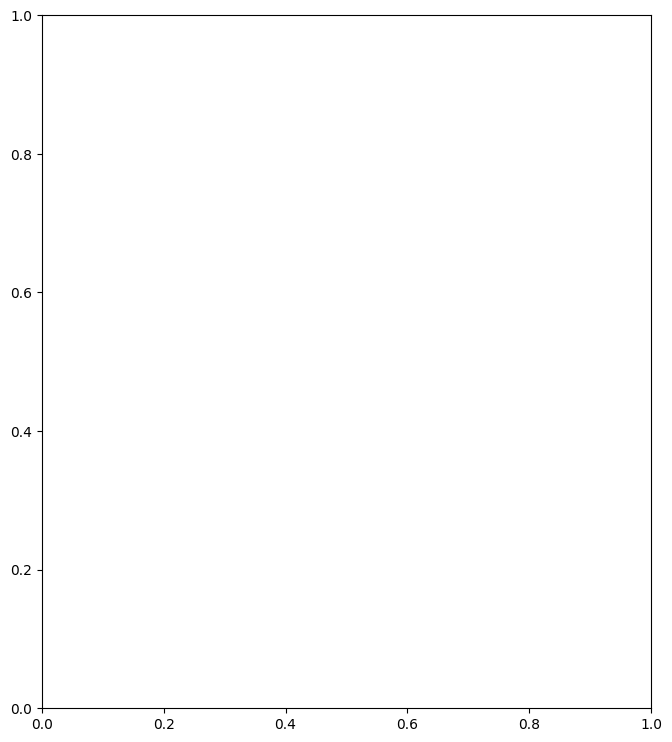

In [ ]:
# This block creates a choropleth map to show how travel time varies across the U.S. Census Tracts.
# We use the `test` GeoDataFrame, which includes both geometry and travel time data.
# The map colors each tract based on the “minutes” column — darker shades represent longer travel times.
# The “fisher_jenks” classification divides the data into natural groupings for better visual clarity.

fig, ax = plt.subplots(figsize=(15,9))

test.plot(
    ax=ax,
    column='RxTmDr',
    cmap='Reds',
    scheme='fisher_jenks',  # natural breaks
    k=5,                    # number of classes (optional)
    edgecolor='white',
    linewidth=0.1,
    legend=True,
    legend_kwds={
        'title': 'Travel time (minutes)',
        'loc': 'upper left',
        'bbox_to_anchor': (1.02, 1.0),   #push legend outside
        'frameon': True
    },
    missing_kwds={'color':'lightgrey', 'label':'No data'}
)

ax.set_title('Travel Time to Buprenorphine by Census Tract', fontsize=14)

ax.set_xlim(-130, -65)   # longitude
ax.set_ylim(23, 50)      # latitude
#ax.set_axis_off()
plt.tight_layout()
plt.show()


To get the above image into your metadata document:

1. Right-click on the image and select **Copy image**
    - The image will be copied into your clipboard
2. Begin editing the appropriate Markdown document directly in the Github interface
    - Be sure you have switched to your branch before you start editing
3. Use `ctrl + v` or `cmd + v` to paste the image directly from your clipboard into the document
    - Pasting the image in will upload it to Github's storage and also create a small HTMl block to link the image into the document.

### What's Next?
Well, now you could take this data and export it as a CSV, or join it back to the geographies and visualize it, or try running this analysis with some different data. Ball is in your court, you got this!


In [ ]:
# Export to csv, dropping unneeded fields at the same time
remove_fields = [
  # very important to remove geometry here
  "geometry",
  # these fields may have come along from the geodata content and aren't needed here
  "ALAND",
  "AWATER",
  "minx",
  "miny",
  "maxx",
  "maxy",
  "BBOX",
  "LABEL",
  "summary_level",
]
test.drop(remove_fields, axis=1, errors="ignore").to_csv('Pharmacy-2025.csv', index=False)


In [ ]:
# Download to your local machine. Don't forget to uncomment the last line!
from google.colab import files
files.download('Pharmacy-2025.csv')
